# Calibration du modèle à volatilité stochastique de Taylor : Filtre de

Kalman

Cheryl KOUADIO  
2025-01-14

# Calibration du modèle à volatilité stochastique de Taylor - Filtre de Kalman

Le modèle à volatilité stochastique de Taylor est un modèle de
volatilité stochastique qui est utilisé pour modéliser la volatilité des
actifs financiers. Le modèle est défini par l’équation suivante :

$$
\begin{aligned}
r_t &= \exp(x_t/2) \cdot \varepsilon_t, \quad \varepsilon_t \sim \text{N}(0,1) \\
x_t &= \mu + \phi \cdot x_{t-1} + \sigma_t \cdot \eta_t
\end{aligned}
$$

où $r_t$ est le rendement de l’actif financier à l’instant $t$, $x_t$
est la volatilité de l’actif financier à l’instant $t$, $\mu$ est la
moyenne de la volatilité, $\phi$ est le coefficient d’autorégression,
$\sigma_t$ est l’écart-type de la volatilité à l’instant $t$, $\eta_t$
est un bruit blanc gaussien, et $\varepsilon_t$ est un bruit blanc
gaussien.

Pour extraire la volatilité, nous utilisons le filtre de Kalman sur le
logarithme des rendements au carré $y_t = \log(r_t^2)$, afin de
linéariser le modèle. Le modèle linéarisé est défini par l’équation
suivante :

$$
y_t = x_t + \varepsilon_t
$$

où $y_t$ est le logarithme des rendements au carré à l’instant $t$,
$x_t$ est la volatilité de l’actif financier à l’instant $t$, et
$\varepsilon_t$ est un bruit blanc de loi log-$\chi^2$.

De ce fait, nous pouvons utiliser le filtre de Kalman pour estimer la
volatilité de l’actif financier en utilisant les rendements observés. En
effet, le filtre de Kalman est un algorithme récursif qui permet
d’estimer l’état caché d’un système dynamique à partir d’observations
bruitées. Il s’applique à des modèles linéaires dont le bruit est
gaussien. Dans notre cas, nous avons linéarisé le modèle pour qu’il soit
compatible avec le filtre de Kalman. Cependant, le bruit n’est pas
gaussien, mais log-$\chi^2$. L’objectif de ce notebook est d’observer le
comportement du filtre de Kalman où le bruit n’est pas gaussien.

Nous possédons déjà d’un fichier avec les rendements de l’actif
financier et la vraie volatilité simulés avec les paramètres suivants
$\mu = -0.8$, $\phi = 0.9$, $\sigma = 0.09$. Nous allons donc utiliser
ces données pour estimer la volatilité de l’actif financier en utilisant
le filtre de Kalman. Néanmoins, le code est également fourni pour
simuler les données si vous souhaitez tester le filtre de Kalman sur
d’autres paramètres.

In [1]:
# Simulation d'un modèle à vol stochastique de Taylor

# r_t = exp(x_t/2)*eps_t (eps_t iid N(0,1))
# x_t = mu + phi * x_{t-1} + sigma_t * eta_t  (eta_t iid N(0,1))

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Paramètres
n = 252
mu = -0.8
phi = 0.9
sigma_squared = 0.09

# Simulation
# np.random.seed(0)

# x = np.zeros(n)
# r = np.zeros(n)

# for t in range(0, n):
#     if t == 0:
#         x[t] = np.random.normal(loc= mu/(1-phi), scale=np.sqrt(sigma_squared/(1-phi**2))) # Densité de transition stationnaire de x_t
#     else:
#         x[t] = mu + phi * x[t-1] + np.sqrt(sigma_squared) * np.random.normal(loc=0, scale=1)
#     r[t] = np.exp(x[t]/2) * np.random.normal(loc=0, scale=1)

data  = pd.read_csv('true_sv_taylor.csv')
r = data['r']
x = data['x']

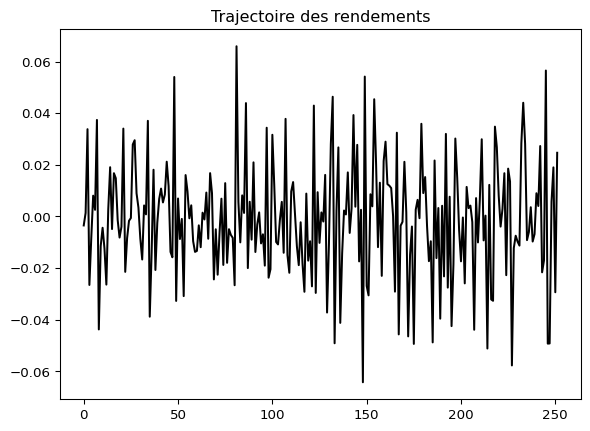

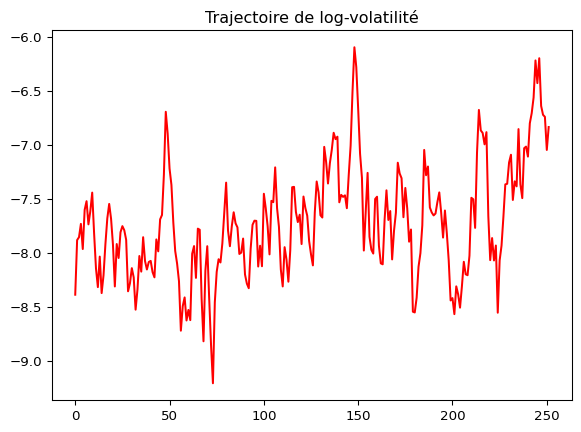

In [2]:
# Affichage des trajectoires
import matplotlib.pyplot as plt

plt.plot(r, color="black")
plt.title("Trajectoire des rendements")
plt.show()

plt.plot(x, color='red')
plt.title("Trajectoire de log-volatilité")
plt.show()

In [3]:
# Construction du modèle log-SV (modèle de Taylor)

# Pour appliquer le filtre de Kalman, il faut que les bruits soient centrés.
mu_r_squared = -1.27 # car log(eps**2) suit une log chi-deux
y = np.log(r**2) - mu_r_squared

## Filtre de Kalman avec paramètres connus

Le filtre de Kalman fonctionne en deux étapes : prédiction et mise à
jour. La prédiction consiste à prédire l’état caché du système à
l’instant $t$ en utilisant les observations jusqu’à l’instant $t-1$. La
mise à jour consiste à mettre à jour l’estimation de l’état caché en
utilisant l’observation à l’instant $t$. Posons :

-   $x_{\text{hat}[t]}$ l’estimation de la volatilité à l’instant $t$,
-   $P[t]$ la matrice de covariance de l’estimation de la volatilité à
    l’instant $t$,
-   $x_{\text{hat\_m}}$ la prédiction de la volatilité à l’instant $t$,
-   $P_m$ la matrice de covariance de la prédiction de la volatilité à
    l’instant $t$,
-   $y[t]$ l’observation à l’instant $t$,
-   $K$ le gain de Kalman.

\$\$

\$\$

Pour initialiser le filtre de Kalman, il est conseillé de connaitre la
loi stationnaire de la volatilité. En effet, la volatilité suit une loi
normale stationnaire de paramètre $\mu/(1 - \phi)$ et
$\sigma^2/(1 - \phi^2)$. Par conséquent, nous pouvons initialiser le
filtre de Kalman avec ces paramètres. En ce qui concerne la matrice de
covariance de l’état initial, nous pouvons la fixer à une valeur élevée,
par exemple $10^2$.

Dans notre cas, nous allons tester deux initialisations différentes :
une initialisation avec les paramètres stationnaires et une
initialisation avec des paramètres aléatoires.

In [4]:
# Script de filtre de kalman pour estimer la volatilité à chaque instant t en supposant les paramètres connus

def kalman_filter(y, mu, phi, sigma_squared, n, init_x, init_P):
    x_hat = np.zeros(n)
    P = np.zeros(n)

    # Initialisation
    x_hat[0] = init_x
    P[0] = init_P # Plus P est grand moins on fait confiance à l'apriori sur la valeur de la volatilité

    for t in range(1, n):
        # Prédiction
        x_hat_m = mu + phi * x_hat[t-1] 
        P_m = phi**2 * P[t-1] + sigma_squared
        y_m = x_hat_m

        # Mise à jour
        K = P_m / (P_m + (np.pi**2)/2)
        P[t] = (1 - K) * P_m
        x_hat[t] = x_hat_m + K * (y[t] - y_m)
    return x_hat, P, K

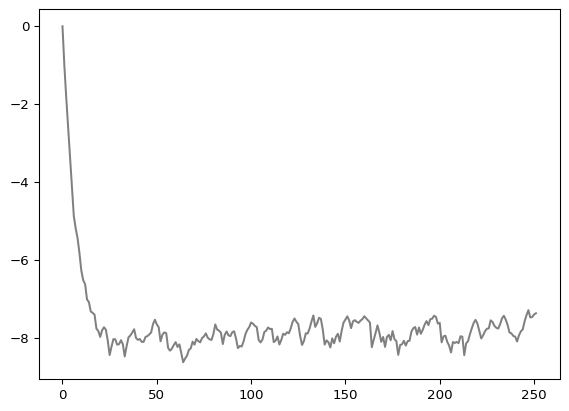

In [5]:
# Initialisation à 0 et 0.01
init_x = 0
init_P = 0.01
x_hat, P, K = kalman_filter(y, mu, phi, sigma_squared, n, init_x, init_P)
plt.plot(x_hat, color='grey', label='Volatilité estimée')

MSE =  0.2794557366826766
MAE =  0.4120099778966342
RMSE =  0.5286357315606622

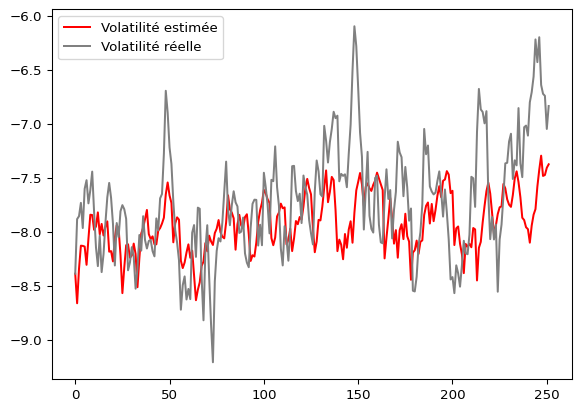

In [6]:
# Initialisation à x_0 et sigma_squared/(1-phi**2)
init_x = x[0]
init_P = sigma_squared/(1-phi**2)
x_hat, P, K = kalman_filter(y, mu, phi, sigma_squared, n, init_x, init_P)
plt.plot(x_hat, color='red', label='Volatilité estimée')
plt.plot(x, color='grey', label = 'Volatilité réelle')
plt.legend()


# Compute MSE, MAE, and RMSE
mse = np.mean((x - x_hat)**2)
mae = np.mean(np.abs(x - x_hat))
rmse = np.sqrt(mse)
print("MSE = ", mse)
print("MAE = ", mae)
print("RMSE = ", rmse)

MSE =  0.27543214871007066
MAE =  0.4078063371140131
RMSE =  0.5248162999660649

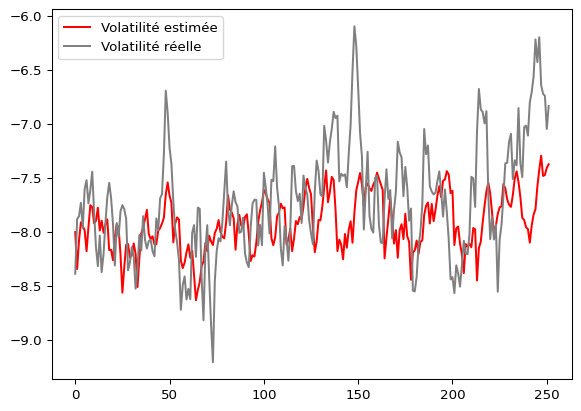

In [7]:
# Initialisation à mu/(1-phi) et sigma_squared/(1-phi**2)
init_x = mu/(1-phi)
init_P = sigma_squared/(1-phi**2)
x_hat, P, K = kalman_filter(y, mu, phi, sigma_squared, n, init_x, init_P)
plt.plot(x_hat, color='red', label='Volatilité estimée')
plt.plot(x, color='grey', label = 'Volatilité réelle')
plt.legend()

# Compute MSE, MAE, RMSE
mse = np.mean((x - x_hat)**2)
mae = np.mean(np.abs(x - x_hat))
rmse = np.sqrt(mse)
print("MSE = ", mse)
print("MAE = ", mae)
print("RMSE = ", rmse)

## Filtre de Kalman avec paramètres inconnus

Dans le cas où les paramètres du modèle sont inconnus, nous pouvons les
estimer en utilisant le filtre de Kalman. En effet, nous pouvons
utiliser l’algorithme EM pour estimer les paramètres du modèle.
L’algorithme EM est un algorithme itératif qui permet d’estimer les
paramètres d’un modèle en maximisant la vraisemblance des données
observées. Dans notre cas, nous allons utiliser l’algorithme EM pour
estimer les paramètres $\mu$, $\phi$ et $\sigma$ du modèle.

In [8]:
import numpy as np
from scipy.optimize import minimize

# Define the log-likelihood function for the log-SV model with Kalman filter
def log_sv_kalman(params, y):
    # Extract parameters
    mu, phi, sigma_eta = params

    # Number of observations
    n = len(y)

    # Initialize state and variance
    x_t = mu  # Initial state (log-volatility)
    P_t = sigma_eta**2 / (1 - phi**2)  # Initial variance (stationarity assumption)

    # Log-likelihood accumulator
    log_likelihood = 0

    for t in range(n):
        # Observation equation: y_t ~ x_t + nu_t

        # Prediction step
        y_t_pred = x_t
        F_t = P_t + np.pi**2 / 2  # Variance of observation noise

        # Update step
        v_t = y[t] - y_t_pred  # Prediction error
        K_t = P_t / F_t  # Kalman gain
        x_t = x_t + K_t * v_t
        P_t = (1 - K_t) * P_t + sigma_eta**2  # Update variance

        # Update log-likelihood
        log_likelihood += -0.5 * (np.log(2 * np.pi) + np.log(F_t) + (v_t**2 / F_t))

        # State evolution
        x_t = mu + phi * (x_t - mu)  # State equation

    return -log_likelihood  # Negative log-likelihood for minimization

# Initial parameter guesses
initial_params = [-0.7, 0.8, np.sqrt(0.05)]

# Constrain phi between -1 and 1 and sigma_eta > 0
bounds = [(-np.inf, np.inf), (-1, 1), (1e-6, np.inf)]

# Optimize parameters using the log-likelihood function
result = minimize(log_sv_kalman, initial_params, args=(y,), bounds=bounds, method='L-BFGS-B')

# Extract estimated parameters
mu_est, phi_est, sigma_eta_est = result.x

# Print results
print("Estimated parameters:")
print(f"mu: {mu_est:.4f}")
print(f"phi: {phi_est:.4f}")
print(f"sigma_eta: {sigma_eta_est:.4f}")

Estimated parameters:
mu: -0.8021
phi: 0.8001
sigma_eta: 1.2184